# Hybrid RL Coverage Experiments for Tabular MDPs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import mdptoolbox.util as util
import mdptoolbox.example as example
import mdptoolbox.mdp as mdpt
from tqdm import tqdm
import sys
sys.path.append('core')
from core import core_mdp, core_env, core_ope
from helpers import *
plt.style.use('matplotlibrc')

np.set_printoptions(suppress=True)

In [2]:
P, R = example.forest(S = 4, r1 = 4, r2 = 2, p=0.1)#.5
#P, R, x_dist = core_env.orig_gridworld_ope_tools()
#R = R.mean(-1).T

# this is as close to 1 as possible
# while still suppressing warnings from mdptoolbox
#gamma = 0.9999999999999999
gamma = 0.9999

# idea: do you wait for a forest to get old to support wildlife,
#       or cut it down for wood each year?
# S is how old the forest can get
# r1 is reward for waiting in oldest state
# r2 is reward for cutting in oldest state
# p is probability forest burns down each year
H = 20
forest = mdpt.ValueIteration(P, R, gamma, H)
forest.run()
nActions = P.shape[0]
nStates = P.shape[1]

# this is the optimal policy!
forest.policy

(0, 0, 0, 0)

In [3]:
np.random.seed(1)
forest_mdp = core_mdp.MDP(P, R, np.ones(nStates)/nStates, 1)
Noff = 100
pi_star = translate_policy(forest.policy, nActions)
pi_unif = np.ones((nStates, nActions))/nActions
pi_bad = (0.6*(1 - pi_star)/(nActions-1) + 0.4*pi_unif)
dataset_optimal = collect_sample(Noff, forest_mdp, 
                         pi_star, H, stationary=True)
dataset_covered = collect_sample(Noff, forest_mdp, 
                         pi_unif, H, stationary=True)
dataset_bad = collect_sample(Noff, forest_mdp, 
                         pi_bad, H, stationary=True)
occ_star = getOcc(dataset_optimal, nStates, nActions)
occ_covered = getOcc(dataset_covered, nStates, nActions)
occ_bad = getOcc(dataset_bad, nStates, nActions)
occ_all = np.ones(occ_star.shape)

In [4]:
occ_star

array([[0.102 , 0.    ],
       [0.0995, 0.    ],
       [0.1045, 0.    ],
       [0.694 , 0.    ]])

In [5]:
thresh = 1/nStates/nActions
part_on_cov = (occ_covered<thresh)
part_on_opt = (occ_star<thresh)
part_on_bad = (occ_bad<thresh)

In [6]:
def ucbvi(mdp, P, R, dataset, nStates, nActions, H, T, delta=0.01):
    # this is as close to 1 as possible
    # while still suppressing warnings from mdptoolbox
    gamma = 0.9999999999999999
    gamma = 0.999#9999999999999

    pis = []
    occupancies = []
    vals = []
    visits = []
    n = len(dataset)
    for t in range(T):
        # getting transition probabilities
        # filling nonstochastic rows with 1/S
        phat = getPhat(dataset, nStates, nActions)
        phat[phat.sum(-1) != 1] = 1/nStates
        
        # getting bonus term and rewards
        n_sa = getN_sa(dataset, nStates, nActions)
        bonus = 2*H*np.sqrt(np.log(nStates*nActions*H*T/delta)/n_sa) #/ 10
        bonus[np.isinf(bonus)] = 0
        bonus[np.isnan(bonus)] = 0
        r = (getR_sa(dataset, nStates, nActions) 
             + bonus)
        
        # value iteration
        vi = mdpt.ValueIteration(phat, r, gamma, H)
        vi.run()
        
        # playing policy, simulating trajectory
        pi = translate_policy(vi.policy, nActions)
        traj = mdp.generate_trajectory(pi, H, stationary=True)
        dataset = np.vstack([dataset, traj[None,...]])
        
        pis.append(pi)
        #dataset_pi = collect_sample(100, mdp, pi, H)
        #occupancies.append(getN_sa(dataset_pi, nStates, nActions)/H/len(dataset_pi))
        
        occupancies.append(getN_sa(dataset[n:], nStates, nActions)/H/(t+1))
        visits.append(getN_sa(dataset[-1:], nStates, nActions))
        #occupancies.append(n_sa/H/len(dataset))
        #vals.append(eval_pi(pi, P, R, nStates, H))
    
        
    return pi, dataset, np.array(pis), np.array(occupancies), np.array(visits)

n_trials = 30
occs_ucb_bad_trials = []
occs_ucb_cov_trials = []
occs_ucb_opt_trials = []
occs_ucb_on_trials = []
visits_ucb_bad_trials = []
visits_ucb_cov_trials = []
visits_ucb_opt_trials = []
visits_ucb_on_trials = []
dataset_ucb_bad_trials = []
dataset_ucb_cov_trials = []
dataset_ucb_opt_trials = []
dataset_ucb_on_trials = []
for i in tqdm(range(n_trials)):  
    pi_ucb_bad, dataset_ucb_bad, pis_ucb_bad, occs_ucb_bad, visits_ucb_bad = ucbvi(
                            forest_mdp, P, R,
                            dataset_bad, nStates, nActions, 
                            H, 200, delta=0.01)

    pi_ucb_cov, dataset_ucb_cov, pis_ucb_cov, occs_ucb_cov, visits_ucb_cov = ucbvi(
                            forest_mdp, P, R,
                            dataset_covered, nStates, nActions, 
                            H, 200, delta=0.01)

    pi_ucb_opt, dataset_ucb_opt, pis_ucb_opt, occs_ucb_opt, visits_ucb_opt = ucbvi(
                            forest_mdp, P, R,
                            dataset_optimal, nStates, nActions, 
                            H, 200, delta=0.01)

    pi_ucb_on, dataset_ucb_on, pis_ucb_on, occs_ucb_on, visits_ucb_on = ucbvi(
                            forest_mdp, P, R,
                            dataset_covered[:1], nStates, nActions, 
                            H, 200, delta=0.01)
    
    occs_ucb_bad_trials.append(occs_ucb_bad)
    occs_ucb_cov_trials.append(occs_ucb_cov)
    occs_ucb_opt_trials.append(occs_ucb_opt)
    occs_ucb_on_trials.append(occs_ucb_on)
    visits_ucb_bad_trials.append(visits_ucb_bad)
    visits_ucb_cov_trials.append(visits_ucb_cov)
    visits_ucb_opt_trials.append(visits_ucb_opt)
    visits_ucb_on_trials.append(visits_ucb_on)
    dataset_ucb_bad_trials.append(dataset_ucb_bad)
    dataset_ucb_cov_trials.append(dataset_ucb_cov)
    dataset_ucb_opt_trials.append(dataset_ucb_opt)
    dataset_ucb_on_trials.append(dataset_ucb_on)

  0%|          | 0/30 [00:00<?, ?it/s]/home/kevin/OneDrive/Documents/UMich/Research/rl-thesis/hybridcov/helpers.py:75: RuntimeWarning: invalid value encountered in divide
  Phat = (Phat/N_sa.T[...,None])
/tmp/ipykernel_401224/296115740.py:20: RuntimeWarning: divide by zero encountered in divide
  bonus = 2*H*np.sqrt(np.log(nStates*nActions*H*T/delta)/n_sa) #/ 10
/home/kevin/OneDrive/Documents/UMich/Research/rl-thesis/hybridcov/helpers.py:63: RuntimeWarning: invalid value encountered in divide
  R_sa = (R_sa/N_sa)
100%|██████████| 30/30 [05:48<00:00, 11.62s/it]


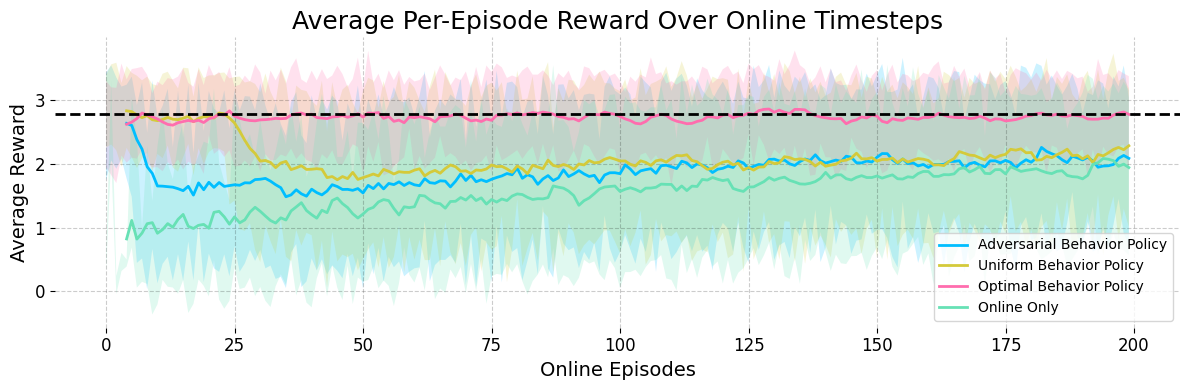

In [7]:
titles = ['Adversarial Behavior Policy', 
          'Uniform Behavior Policy', 
          'Optimal Behavior Policy',
          'Online Only']
datasets = [np.array(dataset_ucb_bad_trials)[:,Noff:,:,-1].mean(-1),
            np.array(dataset_ucb_cov_trials)[:,Noff:,:,-1].mean(-1),
            np.array(dataset_ucb_opt_trials)[:,Noff:,:,-1].mean(-1),
            np.array(dataset_ucb_on_trials)[:,1:,:,-1].mean(-1)]
plt.figure(figsize=(12,4))
for i, title in enumerate(titles):
    plt.plot(pd.Series(datasets[i].mean(0)).rolling(5).mean(), label=title)
    n = len(datasets[i].mean(0))
    plt.fill_between(np.arange(n),
                     datasets[i].mean(0) - 1*datasets[i].std(0),
                     datasets[i].mean(0) + 1*datasets[i].std(0),
                     alpha=0.2)
plt.legend()
plt.xlabel('Online Episodes')
plt.ylabel('Average Reward')
plt.title('Average Per-Episode Reward Over Online Timesteps')
plt.tight_layout()
plt.axhline(dataset_optimal[:,:,-1].mean(-1).mean(), linestyle='dashed',
           label='Optimal Policy Average Reward', color='black')
plt.savefig('figs/reward_tabular.png', dpi=300)

/home/kevin/OneDrive/Documents/UMich/Research/rl-thesis/hybridcov/helpers.py:16: RuntimeWarning: invalid value encountered in divide
  dens = pi_star/pi
/home/kevin/OneDrive/Documents/UMich/Research/rl-thesis/hybridcov/helpers.py:16: RuntimeWarning: divide by zero encountered in divide
  dens = pi_star/pi
/home/kevin/anaconda3/envs/311/lib/python3.11/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


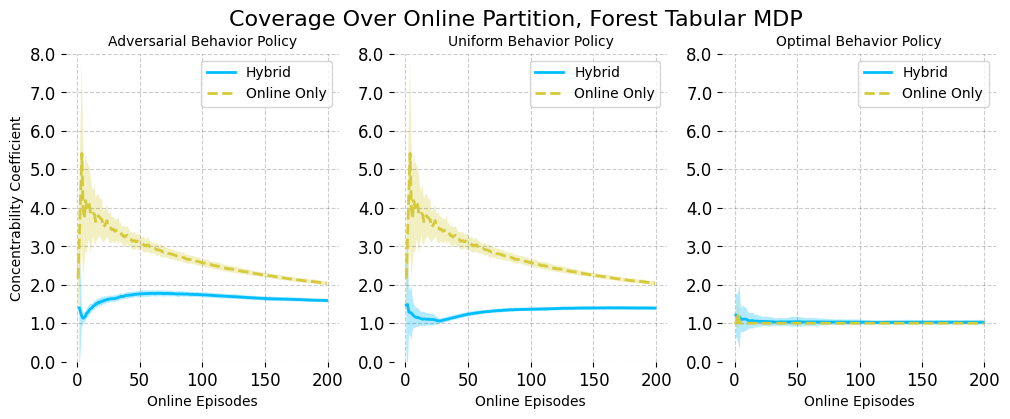

In [8]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
parts = [part_on_bad, part_on_cov, part_on_opt]
occs = [np.array(occs_ucb_bad_trials), np.array(occs_ucb_cov_trials), np.array(occs_ucb_opt_trials)]
titles = ['Adversarial Behavior Policy', 
          'Uniform Behavior Policy', 
          'Optimal Behavior Policy']

for i in range(3):
    cstars_hy = np.array([[c_star(occ_star[parts[i]], occ[parts[i]]) 
                   for occ in occ_t] for occ_t in occs[i]])
    cstars_on = np.array([[c_star(occ_star[parts[i]], occ[parts[i]]) 
                   for occ in occ_t] for occ_t in occs_ucb_on_trials])
    ax[i].plot(cstars_hy.mean(0), linestyle='solid',
         label='Hybrid')
    ax[i].plot(cstars_on.mean(0), linestyle='dashed',
         label='Online Only')
    T = np.array(occs_ucb_bad_trials).shape[1]
    ax[i].fill_between(np.arange(T),
                       cstars_hy.mean(0) - 1.96*cstars_hy.std(0),
                       cstars_hy.mean(0) + 1.96*cstars_hy.std(0),
                      alpha=0.3)
    ax[i].fill_between(np.arange(T),
                       cstars_on.mean(0) - 1.96*cstars_on.std(0),
                       cstars_on.mean(0) + 1.96*cstars_on.std(0),
                      alpha=0.3)
                       
    ax[i].set_title(titles[i], fontsize=10)
    
    ax[i].set_xlabel('Online Episodes', fontsize=10, y=0.05)
    
    #ax[i].set_yscale('symlog')
    ax[i].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    ax[i].legend()
    ax[i].set_ylim(0,8)
    

ax[0].set_ylabel('Concentrability Coefficient', fontsize=10)

plt.suptitle('Coverage Over Online Partition, Forest Tabular MDP', fontsize=16, y=0.99)
plt.savefig('figs/cov_tabular_onpart.png', dpi=300)

# UCB parameter 1

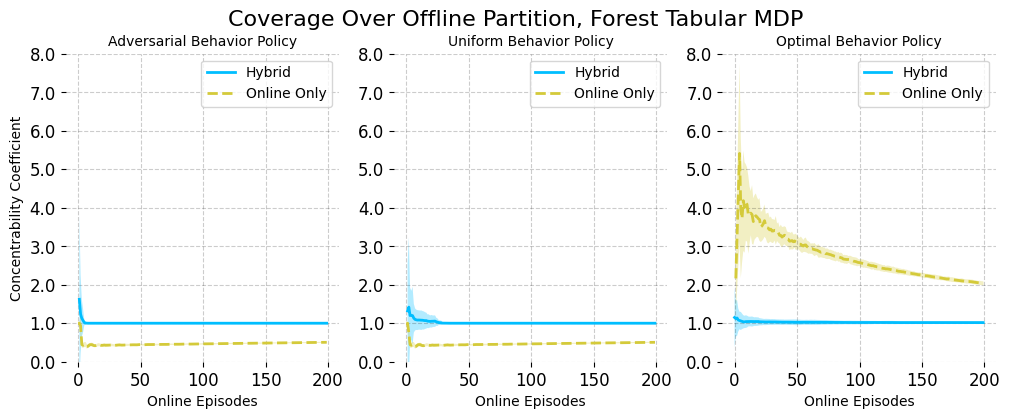

In [9]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
parts = [part_on_bad, part_on_cov, part_on_opt]
occs = [np.array(occs_ucb_bad_trials), np.array(occs_ucb_cov_trials), np.array(occs_ucb_opt_trials)]
titles = ['Adversarial Behavior Policy', 
          'Uniform Behavior Policy', 
          'Optimal Behavior Policy']
for i in range(3):
    cstars_hy = np.array([[c_star(occ_star[~parts[i]], occ[~parts[i]]) 
                   for occ in occ_t] for occ_t in occs[i]])
    cstars_on = np.array([[c_star(occ_star[~parts[i]], occ[~parts[i]]) 
                   for occ in occ_t] for occ_t in occs_ucb_on_trials])
    ax[i].plot(cstars_hy.mean(0), linestyle='solid',
         label='Hybrid')
    ax[i].plot(cstars_on.mean(0), linestyle='dashed',
         label='Online Only')
    T = np.array(occs_ucb_bad_trials).shape[1]
    ax[i].fill_between(np.arange(T),
                       cstars_hy.mean(0) - 1.96*cstars_hy.std(0),
                       cstars_hy.mean(0) + 1.96*cstars_hy.std(0),
                      alpha=0.3)
    ax[i].fill_between(np.arange(T),
                       cstars_on.mean(0) - 1.96*cstars_on.std(0),
                       cstars_on.mean(0) + 1.96*cstars_on.std(0),
                      alpha=0.3)
    ax[i].set_title(titles[i], fontsize=10)
    ax[i].set_xlabel('Online Episodes', fontsize=10, y=0.05)
    #ax[i].set_ylim(0,10)
    ax[i].set_ylim(0,8)
    #ax[i].set_yscale('symlog')
    ax[i].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    ax[i].legend()
ax[0].set_ylabel('Concentrability Coefficient', fontsize=10)

plt.suptitle('Coverage Over Offline Partition, Forest Tabular MDP', fontsize=16, y=0.99)
plt.savefig('figs/cov_tabular_offpart.png', dpi=300)

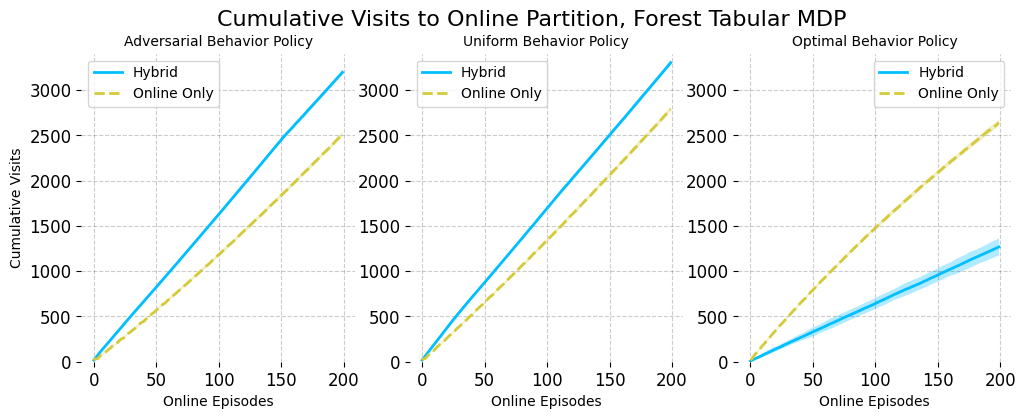

In [10]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
parts = [part_on_bad, part_on_cov, part_on_opt]
visits = [np.array(visits_ucb_bad_trials), np.array(visits_ucb_cov_trials),
          np.array(visits_ucb_opt_trials)]
titles = ['Adversarial Behavior Policy', 
          'Uniform Behavior Policy', 
          'Optimal Behavior Policy']

for i in range(3):
    visit_stat = visits[i][:, :, parts[i]].sum(-1).cumsum(1)
    visit_stat_on = np.array(visits_ucb_on_trials)[:, :, parts[i]].sum(-1).cumsum(1)
    ax[i].plot(visit_stat.mean(0), linestyle='solid',
         label='Hybrid')
    ax[i].plot(visit_stat_on.mean(0), linestyle='dashed',
         label='Online Only')
    ax[i].fill_between(np.arange(len(visit_stat.mean(0))),
                       visit_stat.mean(0)-1.96*visit_stat.std(0),
                       visit_stat.mean(0)+1.96*visit_stat.std(0), alpha=0.3)
    ax[i].fill_between(np.arange(len(visit_stat_on.mean(0))),
                       visit_stat_on.mean(0)-1.96*visit_stat_on.std(0),
                       visit_stat_on.mean(0)+1.96*visit_stat_on.std(0), alpha=0.3)
    ax[i].set_title(titles[i], fontsize=10)
    ax[i].set_xlabel('Online Episodes', fontsize=10, y=0.05)
    ax[i].set_ylim(0,3400)
    ax[i].legend()
ax[0].set_ylabel('Cumulative Visits', fontsize=10)

plt.suptitle('Cumulative Visits to Online Partition, Forest Tabular MDP', fontsize=16, y=0.99)
plt.savefig('figs/visits_tabular_onpart.png', dpi=300)

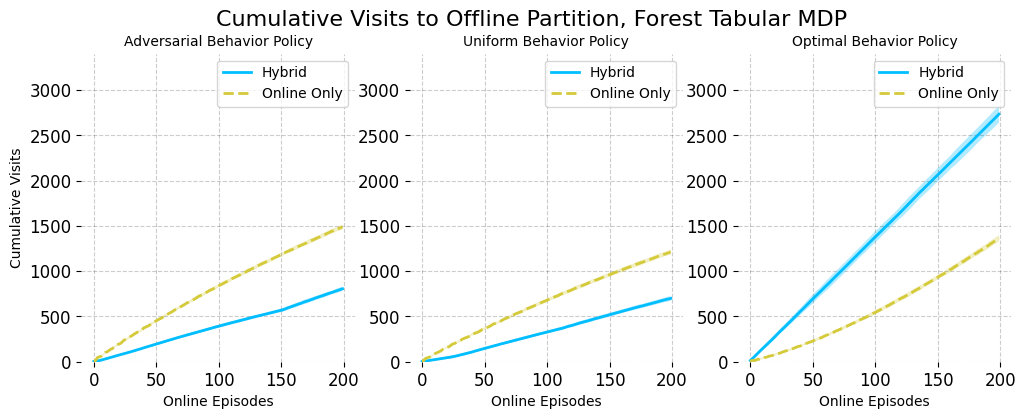

In [11]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
parts = [part_on_bad, part_on_cov, part_on_opt]
visits = [np.array(visits_ucb_bad_trials), np.array(visits_ucb_cov_trials),
          np.array(visits_ucb_opt_trials)]
titles = ['Adversarial Behavior Policy', 
          'Uniform Behavior Policy', 
          'Optimal Behavior Policy']

for i in range(3):
    visit_stat = visits[i][:, :, ~parts[i]].sum(-1).cumsum(1)
    visit_stat_on = np.array(visits_ucb_on_trials)[:, :, ~parts[i]].sum(-1).cumsum(1)
    ax[i].plot(visit_stat.mean(0), linestyle='solid',
         label='Hybrid')
    ax[i].plot(visit_stat_on.mean(0), linestyle='dashed',
         label='Online Only')
    ax[i].fill_between(np.arange(len(visit_stat.mean(0))),
                       visit_stat.mean(0)-1.96*visit_stat.std(0),
                       visit_stat.mean(0)+1.96*visit_stat.std(0), alpha=0.3)
    ax[i].fill_between(np.arange(len(visit_stat_on.mean(0))),
                       visit_stat_on.mean(0)-1.96*visit_stat_on.std(0),
                       visit_stat_on.mean(0)+1.96*visit_stat_on.std(0), alpha=0.3)
    ax[i].set_title(titles[i], fontsize=10)
    ax[i].set_xlabel('Online Episodes', fontsize=10, y=0.05)
    ax[i].set_ylim(0,3400)
    #ax[i].set_ylim(0,10)
    ax[i].legend()
ax[0].set_ylabel('Cumulative Visits', fontsize=10)

plt.suptitle('Cumulative Visits to Offline Partition, Forest Tabular MDP', fontsize=16, y=0.99)
plt.savefig('figs/visits_tabular_offpart.png', dpi=300)